In [1]:
# General import
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from timeit import default_timer as timer
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import datetime

# Keras 2.2 import
import keras
import keras.backend as K
from keras import layers
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.optimizers import SGD, Adagrad, Adam
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# version check python and libraries 
import sys
print(tf.__version__)
print(keras.__version__)
print(sys.version)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

1.8.0
2.2.0
3.6.5 (default, May  3 2018, 10:08:28) 
[GCC 5.4.0 20160609]


In [3]:
## Loss, Metrics Function:
def categorical_acc(y_true, y_pred):
    return np.mean(np.equal(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)))

def custom_loss(y_true, y_pred, margin): 
    """
    calculate custom ranking loss (python)

    Args:
        y_true: labels for a batch of data
        y_pred: predictions for a batch of data
        margin: probability difference that we would like to maintain among 1st, 2nd and others
        
    Returns:
        custom loss averaged over all samples
    """
    # Declare loss variable and variable for number of data points
    loss = 0.0
    n = y_true.shape[0]
    classes = y_true.shape[1]
    # Sort in the label in a descending order
    yt_sorted = np.argsort(-y_true, axis=1) # yt_sorted[:, 0], yt_sorted[:, 1] - 1st, 2nd dominant classes
    
    # Implement custom loss function 
    # i=0 - subtract probability of every other class from 1st, i=1 - subtract probability of every other class except 1st from 2nd
    for i in range(0, 2):
            for j in range(i+1, classes):
                loss += np.log(1 + np.exp(y_pred[np.arange(n), yt_sorted[:,j]] + margin - y_pred[np.arange(n), yt_sorted[:,i]]))
   
    return np.mean(loss)


def custom_loss_k(y_true, y_pred):
    """
        calculate custom ranking loss (used in Keras.compile - loss)

    Args:
        y_true: labels for a batch of data
        y_pred: predictions for a batch of data
        
    Returns:
        custom loss averaged over all samples
    """
    margin = 0.1
    
    # Extract top2 indices from y_true and flatten matrices to use tensor retrieval operation
    flat_sort_idx = K.flatten((tf.nn.top_k(y_true, k=3, sorted=True).indices)) # int32
    
    # Separately extract 1st and 2nd indices from top2 indices on y_true and y_pred respectively
    start_idx = tf.range(tf.shape(y_true)[0]) * K.shape(y_true)[1]
    
    first_idx = K.gather(flat_sort_idx, start_idx)
    second_idx = K.gather(flat_sort_idx, start_idx+1)
    third_idx = K.gather(flat_sort_idx, start_idx+2)
    
    # Calculate indices from viewpoint of flattened 2D(sample, class) to retrieve 1st, 2nd from each sample 
    # * tensor retrieval operation is possible only in the form of 1D    
    first_flat_idx = first_idx + start_idx
    second_flat_idx = second_idx + start_idx
    third_flat_idx = third_idx + start_idx
    
    flat_y_pred = K.flatten(y_pred)
    flat_y_pred = K.cast(flat_y_pred, dtype='float32')
    
    # Tensor retrieval operation: obtain the values of 1st, 2nd dom for each sample using indices, respectively
    first = K.gather(flat_y_pred, first_flat_idx)
    second = K.gather(flat_y_pred, second_flat_idx)
    third = K.gather(flat_y_pred, third_flat_idx)   
        
    loss = K.sum(K.softplus(second + margin - first))
    loss += K.sum(K.softplus(third + margin - first))
    loss += K.sum(K.softplus(third + margin - second))
    
    return K.mean(loss)
    
def first_second_acc(y_true, y_pred):
    """
    Calculate accuracy of predicting both 1st and 2nd dominant class for a batch of data

    Args:
        y_true: labels for a batch of data
        y_pred: predictions for a batch of data
        
    Returns:
        1st, 2nd accuracy      
    """
    y_true_sorted = np.argsort(-y_true, axis=1)
    y_pred_sorted = np.argsort(-y_pred, axis=1)

    return np.mean((y_true_sorted[:,0] == y_pred_sorted[:,0]) & (y_true_sorted[:,1] == y_pred_sorted[:,1]))


def first_second_acc_k(y_true, y_pred):
    """
    Calculate accuracy of predicting both 1st and 2nd dominant class for a batch of data (used in Keras.compile - metrics)

    Args:
        y_true: labels for a batch of data
        y_pred: predictions for a batch of data
        
    Returns:
        1st, 2nd accuracy      
    """
    
    # first_second_accuracy
    true_top2_idx = K.flatten(tf.nn.top_k(y_true, k=2, sorted=True).indices)
    pred_top2_idx = K.flatten(tf.nn.top_k(y_pred, k=2, sorted=True).indices)

    # Flatten matrices of top2 indices to use tensor retrieval operation
    true_first_idx = K.gather(true_top2_idx, tf.range(K.shape(y_true)[0]) * 2)
    true_second_idx = K.gather(true_top2_idx, tf.range(K.shape(y_true)[0]) * 2 + 1)
    pred_first_idx = K.gather(pred_top2_idx, tf.range(K.shape(y_true)[0]) * 2)
    pred_second_idx = K.gather(pred_top2_idx, tf.range(K.shape(y_true)[0]) * 2 + 1)
    
    return K.mean(K.equal(2, K.cast(K.equal(true_first_idx, pred_first_idx), tf.int32) 
                   + K.cast(K.equal(true_second_idx, pred_second_idx), tf.int32)))               

In [4]:
## Workflow Function
def load_data(inp):
    """
    Read data from csv, dat files
    
    Args:
        inp: flag deciding whether to load 2D joint histogram or 3D raw image
        
    Returns:
        data_inp: input data of 2D joint histogram or 3D raw image
        data_out_raw: labels for 2D joint histogram or 3D raw image
    """   
    # input raw 3D data is selected
    # column_names = ['user','timestamp', 'x-axis', 'y-axis', 'z-axis', 'label']
    if inp == 1:
        # Labels for input raw 3D data
        f = open('~/med_project/data/IN_labels_raw_input.dat')
        data_out_raw = np.genfromtxt(f, delimiter='\t')
        f.close
        
        # Input Raw 3D data
        f = open('~/med_project/data/IN_raw_input.dat')
        data_inp = np.genfromtxt(f, delimiter='\t')
        f.close
        data_inp = np.reshape(data_inp, (-1, 70, 83, 80))
        
    # Histogram input is selected
    if inp == 0: 
        # Input Histograms 111 x (147 x 45)
        inp_hist = pd.read_csv('~/med_project/data/INPUT_hist.csv', header = 0, sep = ',')
        data_inp = np.array(inp_hist[0:]) * 1.0 # Making sure that our array is float type (no integer)
        data_inp = np.delete(data_inp, -1, axis=0) # TBD: One data point is discarded to make processing easier (115/5 = 23)
        print(data_inp.shape)
        
        # Labels for Histogram
        out_labels = pd.read_csv('~/med_project/data/IN_labels.csv', header = 0, sep = ',')
        data_out_raw = np.array(out_labels)  # Casting as numpy array
        data_out_raw = np.delete(data_out_raw, -1, axis=0) # One data point is discarded to make processing easier (110/5 = 22)
        print(data_out_raw.shape)
        
    return data_inp, data_out_raw


def reduce_classes(data_out_raw):
    """
    Modify labels of 6 subtypes to a number of classes C to simplify the problem
    
    Args:
        data_out_raw: data labels with 6 classes
        
    Returns:
        data_out: data labels with C grouped classes
    """     
    data_out = np.zeros((data_out_raw.shape[0], classes))
        
    # 3-class(subtype) classification
    data_out[:,0] = data_out_raw[:,0]
    data_out[:,1] = data_out_raw[:,1] + data_out_raw[:,2]
    data_out[:,2] = data_out_raw[:,3] + data_out_raw[:,4]

    # Renormalize to 1 as we discarded the last subtype(y_fibrosis) in the course of grouping subtypes
    data_out = np.transpose(np.transpose(data_out) / np.sum(data_out, axis=1))
       
    return data_out


def cross_val_data_split(data_inp, data_out, i_5set):
    """
    Split data into training and validation according to the ith-cross validation set
    
    Args:
        data_inp: labels for training data
        data_out: predictions for validation data
        i_5set: ith cross validation 
        
    Returns:
        training set (x_train, y_train) and validation set(x_val, y_val)
    """    
    set_size = int(data_out.shape[0] / 5)
    
    ## Dataset split to 5 mini sets
    x_split = np.zeros((5, set_size, data_inp.shape[1], data_inp.shape[2], data_inp.shape[3]))
    y_split = np.zeros((5, set_size, classes))     
    
    for i_split in range(0, 5):
        x_split[i_split, :, :, :] = data_inp[i_split*set_size:(i_split+1)*set_size, :, :, :]
        y_split[i_split, :, :] = data_out[i_split*set_size:(i_split+1)*set_size, :]
    
    # Initialize variables for final model training
    x_train = np.zeros((set_size*4, data_inp.shape[1], data_inp.shape[2], data_inp.shape[3]))
    x_val = np.zeros((set_size, data_inp.shape[1], data_inp.shape[2], data_inp.shape[3]))
    
    y_train = np.zeros((set_size*4, classes))
    y_val = np.zeros((set_size, classes))
    
    # 5-fold cross validation execution 
    x_train[0:set_size, :, :] = x_split[i_5set % 5, :, :, :]
    x_train[set_size:set_size*2, :, :] = x_split[(i_5set+1) % 5, :, :, :]
    x_train[set_size*2:set_size*3, :, :] = x_split[(i_5set+2) % 5, :, :, :]
    x_train[set_size*3:, :, :] = x_split[(i_5set+3) % 5, :, :, :]

    x_val = x_split[(i_5set+4) % 5, :, :, :]

    y_train[0:set_size, :] = y_split[i_5set % 5, :, :]
    y_train[set_size:set_size*2, :] = y_split[(i_5set+1) % 5, :, :]
    y_train[set_size*2:set_size*3, :] = y_split[(i_5set+2) % 5, :, :]
    y_train[set_size*3:, :] = y_split[(i_5set+3) % 5, :, :]

    y_val = y_split[(i_5set+4) % 5, :, :]
 
    return x_train, x_val, y_train, y_val


def baseline_setting(y_train, y_val):
    """
    Set baseline model and evaluate it on training and validation set
    
    Args:
        y_train: labels for training data
        y_val: predictions for validation data
        
    Returns:
        baseline_1st accuracy and 1st, 2nd accuracy for training data and validation data, respectively
    """    
    # predict each class by averaging across all samples
    base_pred = np.mean(y_train, axis=0)
    
    # build a prediction matrix for training and validation
    val_base_pred = np.zeros((y_val.shape)) + base_pred
    train_base_pred = np.zeros((y_train.shape)) + base_pred

    # evaluate on validation set
    val_base_1_acc = categorical_acc(y_val, val_base_pred)
    val_base_12_acc = first_second_acc(y_val, val_base_pred)
    
    # evaluate on training set
    train_base_1_acc = categorical_acc(y_train, train_base_pred)
    train_base_12_acc = first_second_acc(y_train, train_base_pred)

    # stretch out to number of epochs
    val_base_1_acc = np.zeros((n_epoch)) + val_base_1_acc
    val_base_12_acc = np.zeros((n_epoch)) + val_base_12_acc
    train_base_1_acc = np.zeros((n_epoch)) + train_base_1_acc
    train_base_12_acc = np.zeros((n_epoch)) + train_base_12_acc 
    
    return train_base_1_acc, val_base_1_acc, train_base_12_acc, val_base_12_acc, val_base_pred


def visualize_results(results):
    """
    Visualize performace in plots and graphs
    
    Args:
        results: matrix of loss and metrics per epoch
        
    Returns:
        show and save figures on train/val results
    """
    # Create x-axis: a sequence of evaluation epochs
    # [start], stop(excluded), [step] e.g. 2, 102, 2 -> 2,4,...98,100
    x = np.arange(av_epoch, n_epoch+1, av_epoch) 
             
    plt.figure(figsize=(30, 10))
    plt.rc('font',**{'size':25})
    plt.subplot(1,3,1)
    plt.plot(x, results[4], label = 'Training')
    plt.plot(x, results[5], label = 'Validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(x, results[0], label = 'Training Baseline')
    plt.plot(x, results[1], label = 'Val Baseline')
    plt.plot(x, results[6], label = 'Training')
    plt.plot(x, results[7], label = 'Validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('1st accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1,3,3)
    plt.plot(x, results[2], label = 'Training Baseline')
    plt.plot(x, results[3], label = 'Val Baseline')
    plt.plot(x, results[8], label = 'Training')
    plt.plot(x, results[9], label = 'Validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('1st_2nd Accuracy')
    plt.legend(loc='lower right')

    plt.suptitle('Results : {}   model: {}   obj: {}'.format(now, model_name, objective), fontsize=20)
    plt.savefig('Results/time: {}__model: {}__obj: {}.png'.format(now, model_name, objective))
    plt.show()
    
def get_confusion_mat(y_true, y_pred):
    """
    Visualize performace in plots and graphs
    
   Args:
        y_true: labels for a batch of data
        y_pred: predictions for a batch of data
        
    Returns:
        Show and save figures on train/val results
    """
    conf_mat = np.zeros((classes, classes))

    y_true_c = np.argmax(y_true, axis=1)
    y_pred_c = np.argmax(y_pred, axis=1)

    for i in range(y_true.shape[0]):
        conf_mat[y_true_c[i], y_pred_c[i]] = conf_mat[y_true_c[i], y_pred_c[i]] + 1
    
    return conf_mat

In [5]:
## Keras Model Function
def new_model(x_dim, k_mod, obj):
    """
    Build a Keras model of our own configuration
    
   Args:
        x_dim: input dimension of the image
        k_mod: index for the desired model
        obj: index for the desired objective function 
        
    Returns:
       Keras model of our own configuration
    """
    model = Sequential()
    
    # Model Architecture
    if k_mod == 1: # 'linear'
        model.add(Flatten(input_shape=(x_dim[0], x_dim[1], x_dim[2])))
        model.add(Dense(classes, activation='softmax', kernel_regularizer = l1(reg), kernel_initializer='he_normal'))

    if k_mod == 2: # 'mlp: 3-layer Neural Network'
        model.add(Flatten(input_shape=(x_dim[0], x_dim[1], x_dim[2])))
        model.add(Dense(64, activation = 'relu', kernel_regularizer = l1(reg), kernel_initializer='he_normal'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation = 'relu', kernel_regularizer = l1(reg), kernel_initializer='he_normal'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation = 'relu', kernel_regularizer = l1(reg), kernel_initializer='he_normal'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax', kernel_regularizer = l1(reg), kernel_initializer='he_normal'))
        
    if k_mod == 3: # 'cnn_2d': Vanila 2D CNN
        model.add(Conv2D(32, 7, activation='relu', input_shape=(x_dim[0], x_dim[1], x_dim[2])))
        model.add(Conv2D(32, 7, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu', kernel_regularizer = l1(reg), kernel_initializer='he_normal'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax', kernel_regularizer = l1(reg), kernel_initializer='he_normal'))
        
        
    if k_mod == 4: # cnn_2d_multi-input
        ggo_input = Input(shape=(x_dim[0], x_dim[1], x_dim[2]), dtype='float32', name='ggo')
        vnc_input = Input(shape=(x_dim[0], x_dim[1], x_dim[2]), dtype='float32', name='vnc')
        
        ggo_conv1 = layers.Conv2D(32, 3, activation='relu') (ggo_input)
        ggo_conv2 = layers.Conv2D(64, 3, activation='relu') (ggo_conv1)
        ggo_features = layers.MaxPooling2D((2,2), strides=(2,2)) (ggo_conv2)
        
        vnc_conv1 = layers.Conv2D(32, 3, activation='relu') (vnc_input)
        vnc_conv2 = layers.Conv2D(64, 3, activation='relu') (vnc_conv1)
        vnc_features = layers.MaxPooling2D((2,2), strides=(2,2)) (vnc_conv2)
        
        concatenated = layers.concatenate([ggo_features,vnc_features], axis=-1)
        
        input_vector = layers.Flatten() (concatenated)
        
        fc1 = layers.Dense(128, activation='relu', kernel_regularizer = l1(reg), kernel_initializer='he_normal') (input_vector)
        fc1_drop = layers.Dropout(0.5) (fc1)
        
        fc2 = layers.Dense(128, activation='relu', kernel_regularizer = l1(reg), kernel_initializer='he_normal') (fc1_drop)
        fc2_drop = layers.Dropout(0.5) (fc2)
        output = layers.Dense(classes, activation='softmax', kernel_regularizer = l1(reg), kernel_initializer='he_normal')(fc2_drop)
        # model = Model([ggo_input, vnc_input], output)
        
    if obj == 1:
        model.compile(optimizer = Adam(lr=l_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                      loss = custom_loss_k,
                      metrics=['categorical_accuracy', first_second_acc_k])  
        
    if obj == 2:
        model.compile(optimizer = Adam(lr=l_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                      loss = 'categorical_crossentropy', 
                      metrics=['categorical_accuracy', first_second_acc_k])
    
    
    return model

In [6]:
def run(k_mod, obj, inp):
    """
    Run a process of machine learning once
    
   Args:
        x_dim: input dimension of the image
        k_mod: index for the desired model
        obj: index for the desired objective function 
        
    Returns:
       result on metrics of a one run
    """
    
    # Load input, labels and reduce classes
    data_inp, data_out_raw = load_data(inp) # load dataset    
    data_out = reduce_classes(data_out_raw) # reduce labels of 6 classes to simplify the problem
        
        
    # Declare variables
    results = np.zeros(((n_metrics+3)*2, n_epoch)) # result matrix for model training
    x_dim = np.zeros(3, dtype=np.int32)

    conf_mat = np.zeros((classes, classes))
    conf_mat_b = np.zeros((classes, classes))
    
    # Shuffle of data segments
    # int......any number (should not be changed across different methods)
    
    data_inp, data_out = shuffle(data_inp, data_out, random_state = 20) # Pseudo-random shuffling
    data_inp = preprocessing.scale(data_inp) # Zero mean + Unit variance Normalization
    data_inp = np.reshape(data_inp, (-1, 147, 45, 1))
    x_dim[0:3] = [data_inp.shape[1], data_inp.shape[2], data_inp.shape[3]] # size of 2D histogram (input) 
    
    for i_5set in range(0, 5):
        x_train, x_val, y_train, y_val = cross_val_data_split(data_inp, data_out, i_5set)
        
        ## Evaluating Baseline: an average of probabilities across each class in the training set
        train_base_1_acc, val_base_1_acc, train_base_12_acc, val_base_12_acc, y_pred_val = baseline_setting(y_train, y_val)
        results[0] += train_base_1_acc
        results[1] += val_base_1_acc
        results[2] += train_base_12_acc
        results[3] += val_base_12_acc
        
        model = new_model(x_dim, k_mod, obj)
        
        if i_5set == 0:
            print(model.summary())
    
        # Train for one-fold
        hist = model.fit(x_train, y_train, batch_size=22, epochs=n_epoch, verbose=2, validation_data=(x_val, y_val))         
        
        for i in range(4, (n_metrics+3)*2): # save results of one-fold
            results[i] += np.array(hist.history[metric_dict[i]])
        
        # Print progress within each validation set
        if prin_t:
            print (i_5set+1), " / 5" 

        
    for i in range(0, (n_metrics+3)*2):
        results[i] /= 5
        
    # Round the results to the nearest 10,000s
    results = np.around(results, decimals = 4)
    
    # build confusion matrix
    y_pred = np.zeros((data_out.shape[0], data_out.shape[1])) + np.mean(data_out, axis=0)
    conf_mat_b = get_confusion_mat(data_out, y_pred)
    conf_mat = get_confusion_mat(data_out, model.predict(data_inp))
    
    print('confusion matrix for prediction', conf_mat)
    print('confusion matrix for baseline', conf_mat_b)
    model.save('Results/time: {}____model: {}____obj: {}____1_val_acc: {}____12_val_acc: {}____.h5'.format
               (now, model_name, objective, np.max(results[7]), np.max(results[9])))
    

    return results

(115, 6615)
(115, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 141, 39, 32)       1600      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 135, 33, 32)       50208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 67, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 34304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2195520   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 92 samples, validate on 23 samples
Epoch 1/50
 - 2s - loss: 874.8943 - categorical_accuracy: 0.6739 - first_second_acc_k: 0.4783 - val_loss: 636.0655 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
Epoch 2/50
 - 0s - loss: 544.7297 - categorical_accuracy: 0.7174 - first_second_acc_k: 0.3370 - val_loss: 409.8086 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
Epoch 3/50
 - 0s - loss: 394.3119 - categorical_accuracy: 0.7500 - first_second_acc_k: 0.5326 - val_loss: 338.4852 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.5652
Epoch 4/50
 - 0s - loss: 334.5404 - categorical_accuracy: 0.6739 - first_second_acc_k: 0.4130 - val_loss: 342.0344 - val_categorical_accuracy: 0.1739 - val_first_second_acc_k: 0.1739
Epoch 5/50
 - 0s - loss: 339.2262 - categorical_accuracy: 0.4457 - first_second_acc_k: 0.3370 - val_loss: 356.2497 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
Epoch 6/50
 - 0s - loss: 364.1614 - categ

Epoch 46/50
 - 0s - loss: 210.0996 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.5761 - val_loss: 199.5207 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
Epoch 47/50
 - 0s - loss: 198.3793 - categorical_accuracy: 0.7391 - first_second_acc_k: 0.5870 - val_loss: 239.5602 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
Epoch 48/50
 - 0s - loss: 263.1076 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.5870 - val_loss: 279.7014 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
Epoch 49/50
 - 0s - loss: 278.9000 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.5978 - val_loss: 270.4870 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
Epoch 50/50
 - 0s - loss: 263.9016 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.5978 - val_loss: 253.4518 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6957
1
Train on 92 samples, validate on 23 samples
Epoch 1/50
 - 1s - loss: 888.1991 

Epoch 41/50
 - 0s - loss: 177.9696 - categorical_accuracy: 0.7935 - first_second_acc_k: 0.6087 - val_loss: 176.4662 - val_categorical_accuracy: 0.6522 - val_first_second_acc_k: 0.4783
Epoch 42/50
 - 0s - loss: 174.0154 - categorical_accuracy: 0.7935 - first_second_acc_k: 0.5652 - val_loss: 177.4521 - val_categorical_accuracy: 0.6522 - val_first_second_acc_k: 0.3913
Epoch 43/50
 - 0s - loss: 171.5834 - categorical_accuracy: 0.7935 - first_second_acc_k: 0.5217 - val_loss: 179.0729 - val_categorical_accuracy: 0.6522 - val_first_second_acc_k: 0.4783
Epoch 44/50
 - 0s - loss: 172.6438 - categorical_accuracy: 0.7935 - first_second_acc_k: 0.5109 - val_loss: 178.7596 - val_categorical_accuracy: 0.6522 - val_first_second_acc_k: 0.4348
Epoch 45/50
 - 0s - loss: 171.3034 - categorical_accuracy: 0.7935 - first_second_acc_k: 0.3804 - val_loss: 174.4330 - val_categorical_accuracy: 0.6522 - val_first_second_acc_k: 0.3913
Epoch 46/50
 - 0s - loss: 172.3724 - categorical_accuracy: 0.7935 - first_second

Epoch 36/50
 - 0s - loss: 195.3206 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.5978 - val_loss: 202.6758 - val_categorical_accuracy: 0.7391 - val_first_second_acc_k: 0.5652
Epoch 37/50
 - 0s - loss: 199.7142 - categorical_accuracy: 0.7717 - first_second_acc_k: 0.6304 - val_loss: 197.7243 - val_categorical_accuracy: 0.7391 - val_first_second_acc_k: 0.5652
Epoch 38/50
 - 0s - loss: 196.2201 - categorical_accuracy: 0.7717 - first_second_acc_k: 0.6196 - val_loss: 201.0792 - val_categorical_accuracy: 0.7391 - val_first_second_acc_k: 0.5652
Epoch 39/50
 - 0s - loss: 195.2794 - categorical_accuracy: 0.7500 - first_second_acc_k: 0.6087 - val_loss: 200.8909 - val_categorical_accuracy: 0.7391 - val_first_second_acc_k: 0.5652
Epoch 40/50
 - 0s - loss: 196.9653 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.6196 - val_loss: 207.2413 - val_categorical_accuracy: 0.7391 - val_first_second_acc_k: 0.5652
Epoch 41/50
 - 0s - loss: 208.0367 - categorical_accuracy: 0.7717 - first_second

Epoch 31/50
 - 0s - loss: 177.3412 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.4565 - val_loss: 179.7040 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.4348
Epoch 32/50
 - 0s - loss: 181.3427 - categorical_accuracy: 0.7500 - first_second_acc_k: 0.5326 - val_loss: 193.8207 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6522
Epoch 33/50
 - 0s - loss: 188.3035 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.5978 - val_loss: 185.4540 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6522
Epoch 34/50
 - 0s - loss: 186.2053 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.6087 - val_loss: 180.1592 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6522
Epoch 35/50
 - 0s - loss: 181.0169 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.5870 - val_loss: 177.1960 - val_categorical_accuracy: 0.7826 - val_first_second_acc_k: 0.6087
Epoch 36/50
 - 0s - loss: 179.4962 - categorical_accuracy: 0.7609 - first_second

Epoch 26/50
 - 0s - loss: 182.7711 - categorical_accuracy: 0.7391 - first_second_acc_k: 0.5978 - val_loss: 185.6292 - val_categorical_accuracy: 0.8696 - val_first_second_acc_k: 0.6957
Epoch 27/50
 - 0s - loss: 183.3212 - categorical_accuracy: 0.7391 - first_second_acc_k: 0.5652 - val_loss: 180.1713 - val_categorical_accuracy: 0.8696 - val_first_second_acc_k: 0.6957
Epoch 28/50
 - 0s - loss: 180.9070 - categorical_accuracy: 0.7391 - first_second_acc_k: 0.5761 - val_loss: 179.8075 - val_categorical_accuracy: 0.8696 - val_first_second_acc_k: 0.6957
Epoch 29/50
 - 0s - loss: 180.0748 - categorical_accuracy: 0.7391 - first_second_acc_k: 0.5978 - val_loss: 172.9262 - val_categorical_accuracy: 0.8696 - val_first_second_acc_k: 0.6957
Epoch 30/50
 - 0s - loss: 179.8049 - categorical_accuracy: 0.7609 - first_second_acc_k: 0.6087 - val_loss: 173.1906 - val_categorical_accuracy: 0.8696 - val_first_second_acc_k: 0.6957
Epoch 31/50
 - 0s - loss: 178.1374 - categorical_accuracy: 0.7065 - first_second

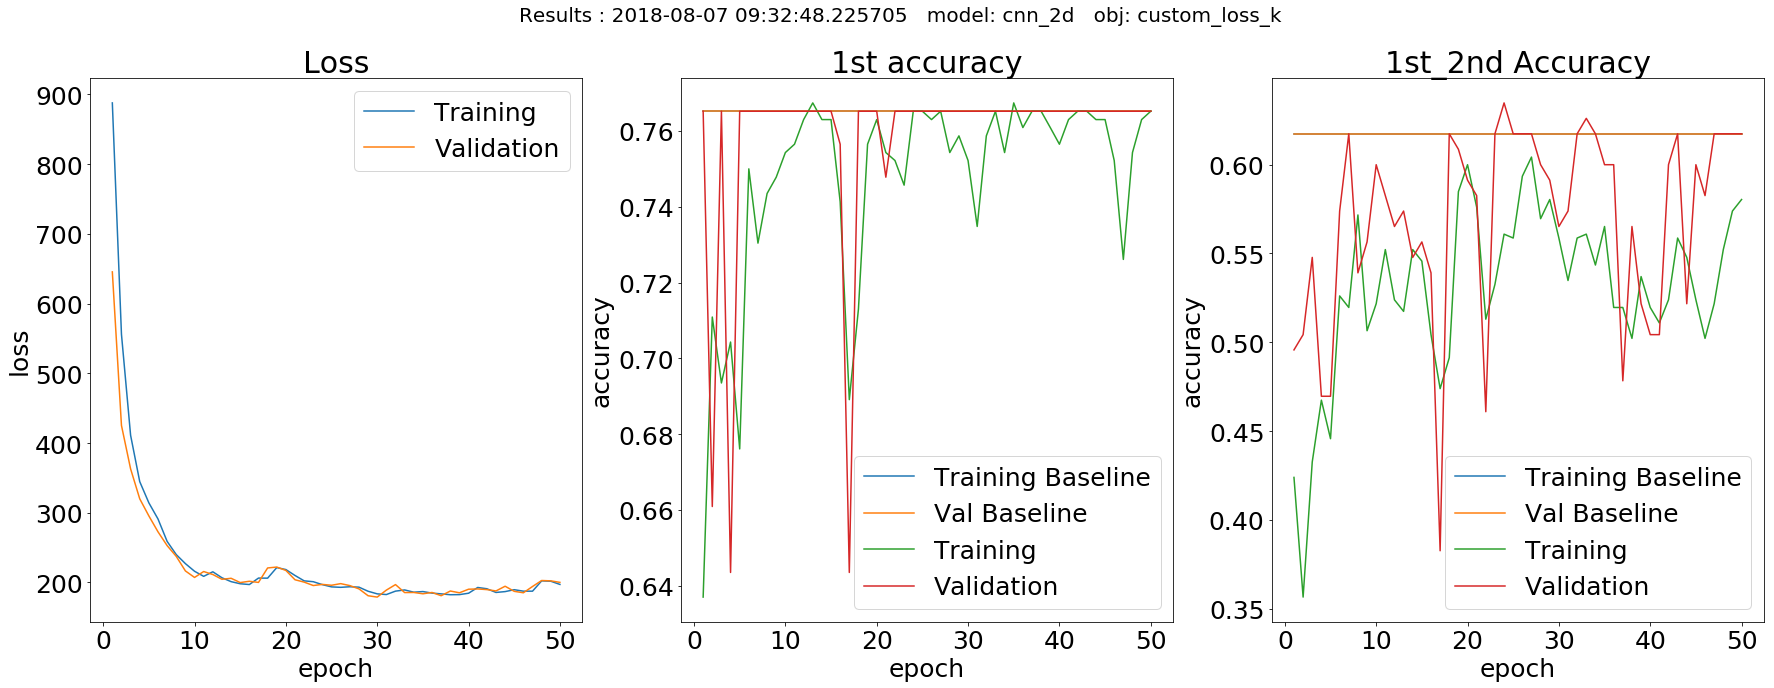

All DONE!  ->  Results saved with date:  <built-in method now of type object at 0x9e9120>


In [7]:
## Script 
SEED = 3
np.random.seed(SEED)

# Settings ---------------------------------------------------------------------------------------------
# List of available models, objectives, and metrics
keras_model_dict = {'linear':1, 'mlp':2, 'cnn_2d':3}

objective_dict = {'custom_loss_k':1, 'cross_entropy':2}

metric_dict = {0:'base_acc_train', 1:'base_acc_val', 2:'base_acc2_train', 3:'base_acc2_val', 
                    4:'loss', 5:'val_loss', 6:'categorical_accuracy', 7:'val_categorical_accuracy', 
                    8:'first_second_acc_k', 9:'val_first_second_acc_k'}

# Hyperparameters to TUNE
n_epoch         = 50    # int......any number
n_metrics       = 2      # 1st accuracy, 1st_2nd accuracy
av_epoch       = 1        # Evaluation will be done every x epochs (must be denominator of n_epoch)
l_rate             = 0.005     # float....learning_rate > 0 
reg                = 0.1    # float....reg_lambda > 0 (for output softmax layer)

# Keras model settings
model_name = 'cnn_2d'  
objective       = 'custom_loss_k'
inp                = False    # Make true, if you want to use raw input data instead of histogram
classes          = 3        # Reduce output label to C classes
prin_t            = True
now              = datetime.datetime.now() 

## Execution --------------------------------------------------------------------------------------------

# 2. Get results for one specific configuration                
results = run(k_mod = keras_model_dict[model_name], 
              obj = objective_dict[objective], 
              inp = inp)

# 3. Print out the best epoch with result for each metric
print('[{} Best Result Summary]'.format(model_name))
for i in range(0, (n_metrics+3)*2):
    if i <= 5: 
        print('epoch: {}'.format(np.argmin(results[i])+1), '{}: {}'.format(metric_dict[i], np.min(results[i])))
    else:    
        print('epoch: {}'.format(np.argmax(results[i])+1), '{}: {}'.format(metric_dict[i], np.max(results[i])))
        
# Plot graphs of baseline, training, and validation performance on each metric        
visualize_results(results) 

# Done statement
print('All DONE!  ->  Results saved with date: ', datetime.datetime.now)